In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
import gc
import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fontdict = {'fontsize':20, 'fontweight':'bold'}

num_list = []
for a in range(2):
    for b in range(2) :
        num_list.append((a,b))
        

In [2]:
survey_multi = pd.read_csv('multipleChoiceResponses.csv')
qn_list = survey_multi.iloc[0,:].values.tolist()
survey_multi = survey_multi.iloc[1:, ]

# 질문 리스트 생성
pd.concat([pd.Series(survey_multi.columns), pd.Series(qn_list)],1).to_excel('qn_list.xlsx')

In [19]:
survey_multi.groupby(['Q3', 'Q9']).size()

Q3                                                    Q9                                                          
Argentina                                             0-10,000                                                         30
                                                      10-20,000                                                        34
                                                      100-125,000                                                       3
                                                      125-150,000                                                       1
                                                      20-30,000                                                         9
                                                      30-40,000                                                         8
                                                      40-50,000                                                         3
                               

In [3]:
survey_multi.shape

(23859, 395)

In [4]:
survey_multi.loc[survey_multi['Q3']=='South Korea', :].isnull().sum()

Time from Start to Finish (seconds)      0
Q1                                       0
Q1_OTHER_TEXT                            0
Q2                                       0
Q3                                       0
Q4                                      10
Q5                                      13
Q6                                      16
Q6_OTHER_TEXT                            0
Q7                                      28
Q7_OTHER_TEXT                            0
Q8                                      29
Q9                                      40
Q10                                     36
Q11_Part_1                             126
Q11_Part_2                             151
Q11_Part_3                             156
Q11_Part_4                             148
Q11_Part_5                             144
Q11_Part_6                             170
Q11_Part_7                             182
Q11_OTHER_TEXT                           0
Q12_MULTIPLE_CHOICE                     48
Q12_Part_1_

In [5]:
def per_df(col1) :
    per_results = survey_multi[col1].value_counts() / survey_multi[col1].value_counts().sum()
    return per_results   

## 여성 Data scientist를 주제로 해보면 어떨까?

Text(0.5,1,'Age')

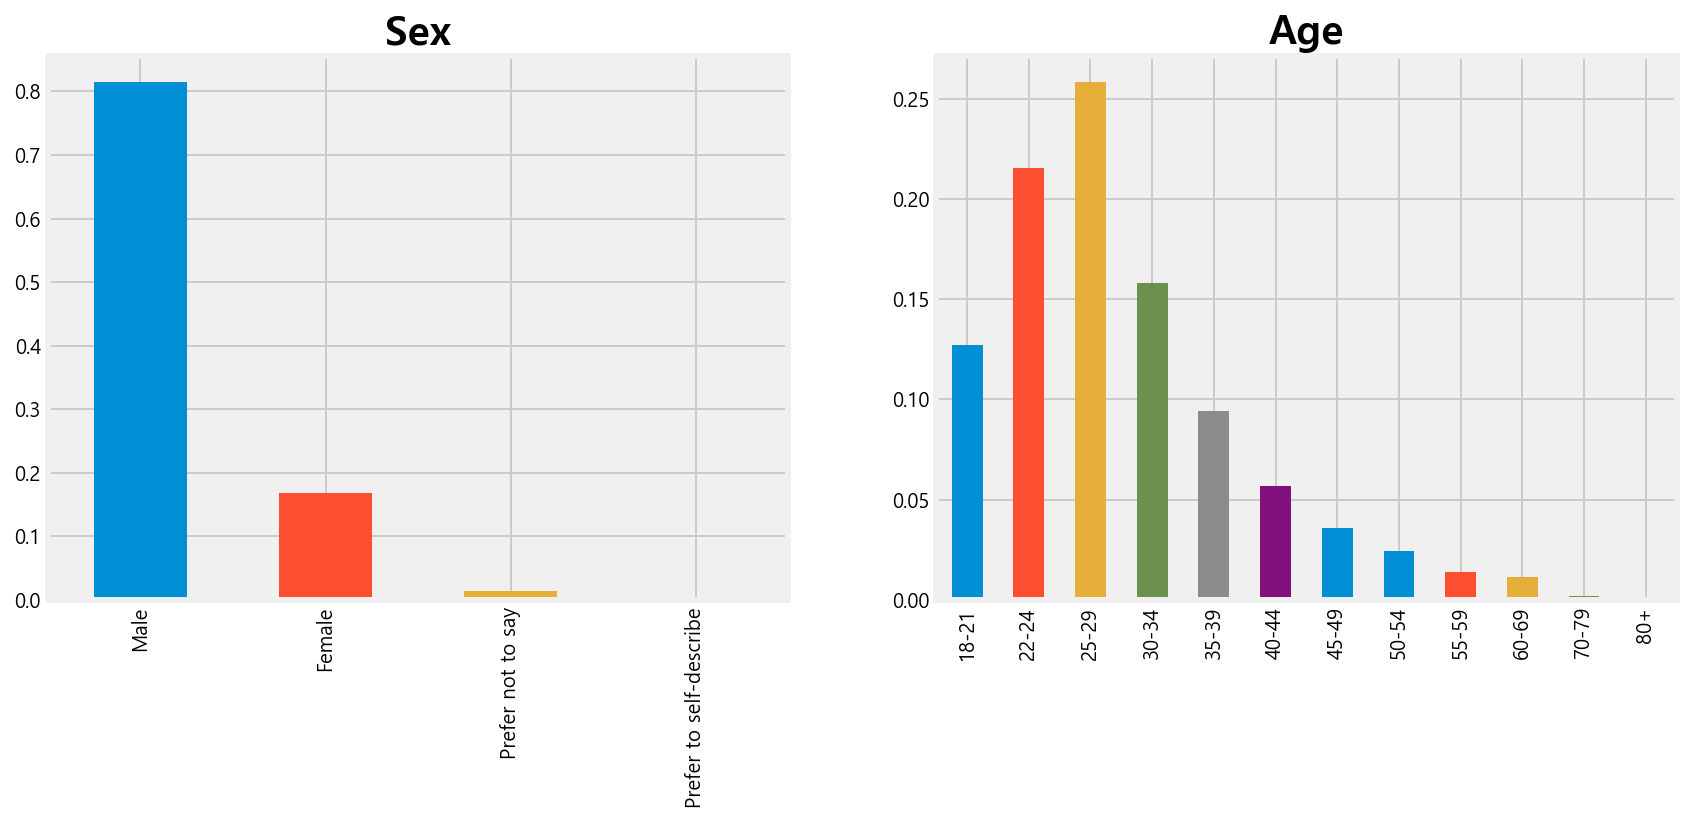

In [6]:
f, ax = plt.subplots(1,2, figsize=(13,5))
per_df('Q1').plot.bar(ax=ax[0]).set_title('Sex', fontdict=fontdict)
per_df('Q2').sort_index().plot.bar(ax=ax[1]).set_title('Age', fontdict=fontdict)

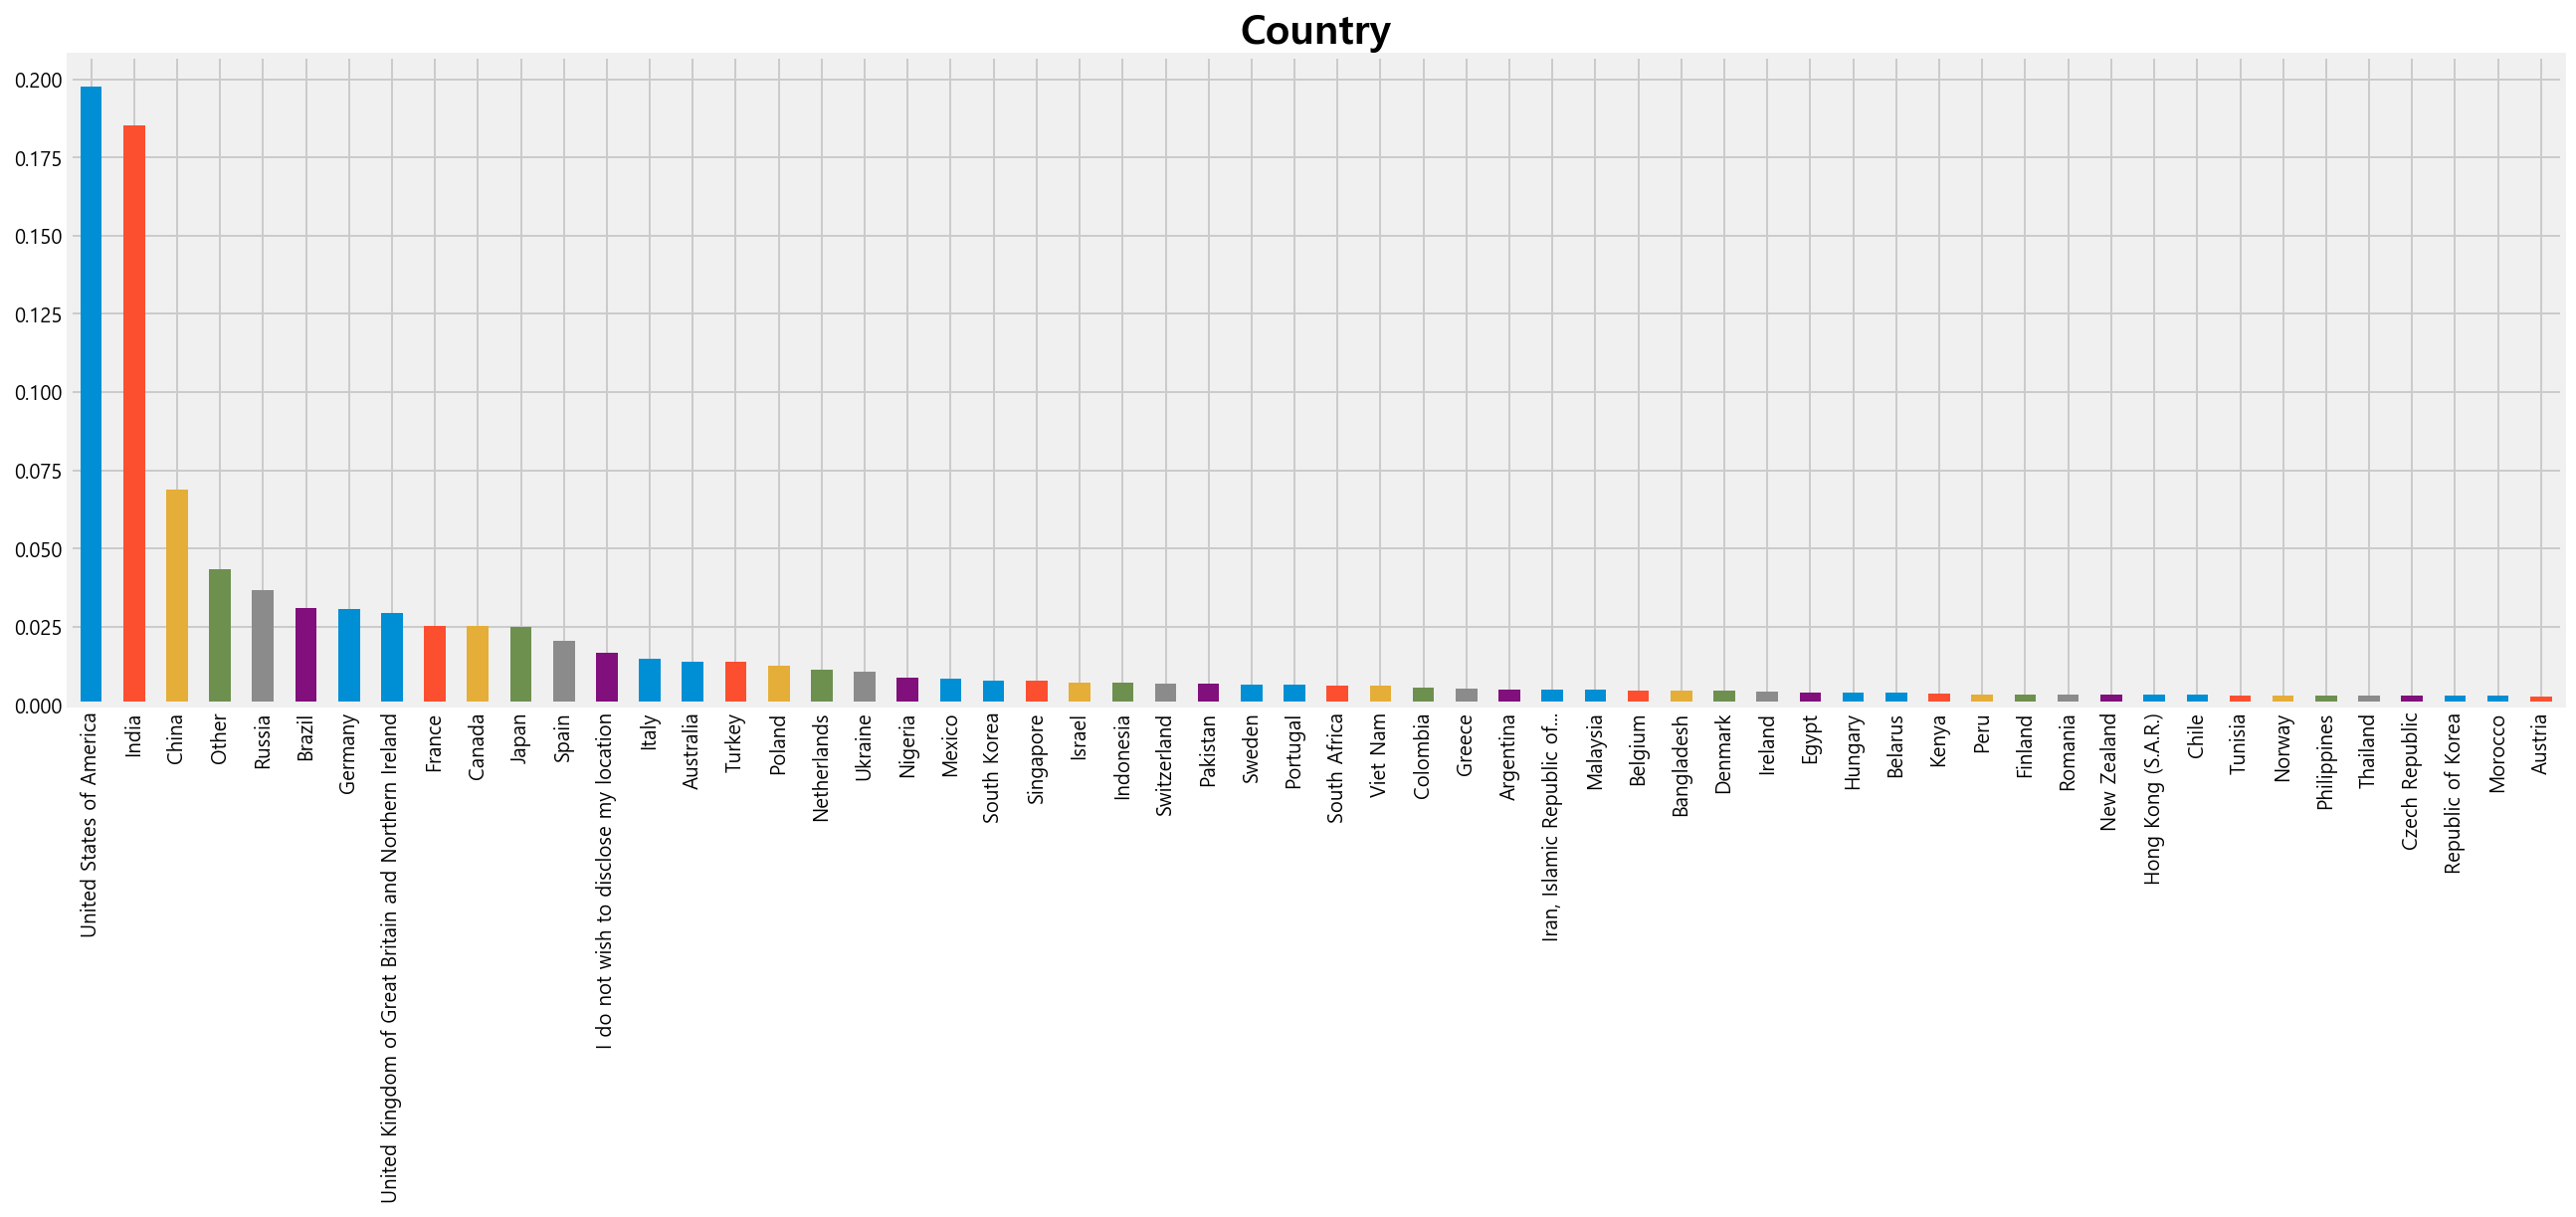

In [7]:
g = per_df('Q3').plot.bar(figsize=(20,6)).set_title('Country', fontdict=fontdict)

Text(0.5,1,'Major')

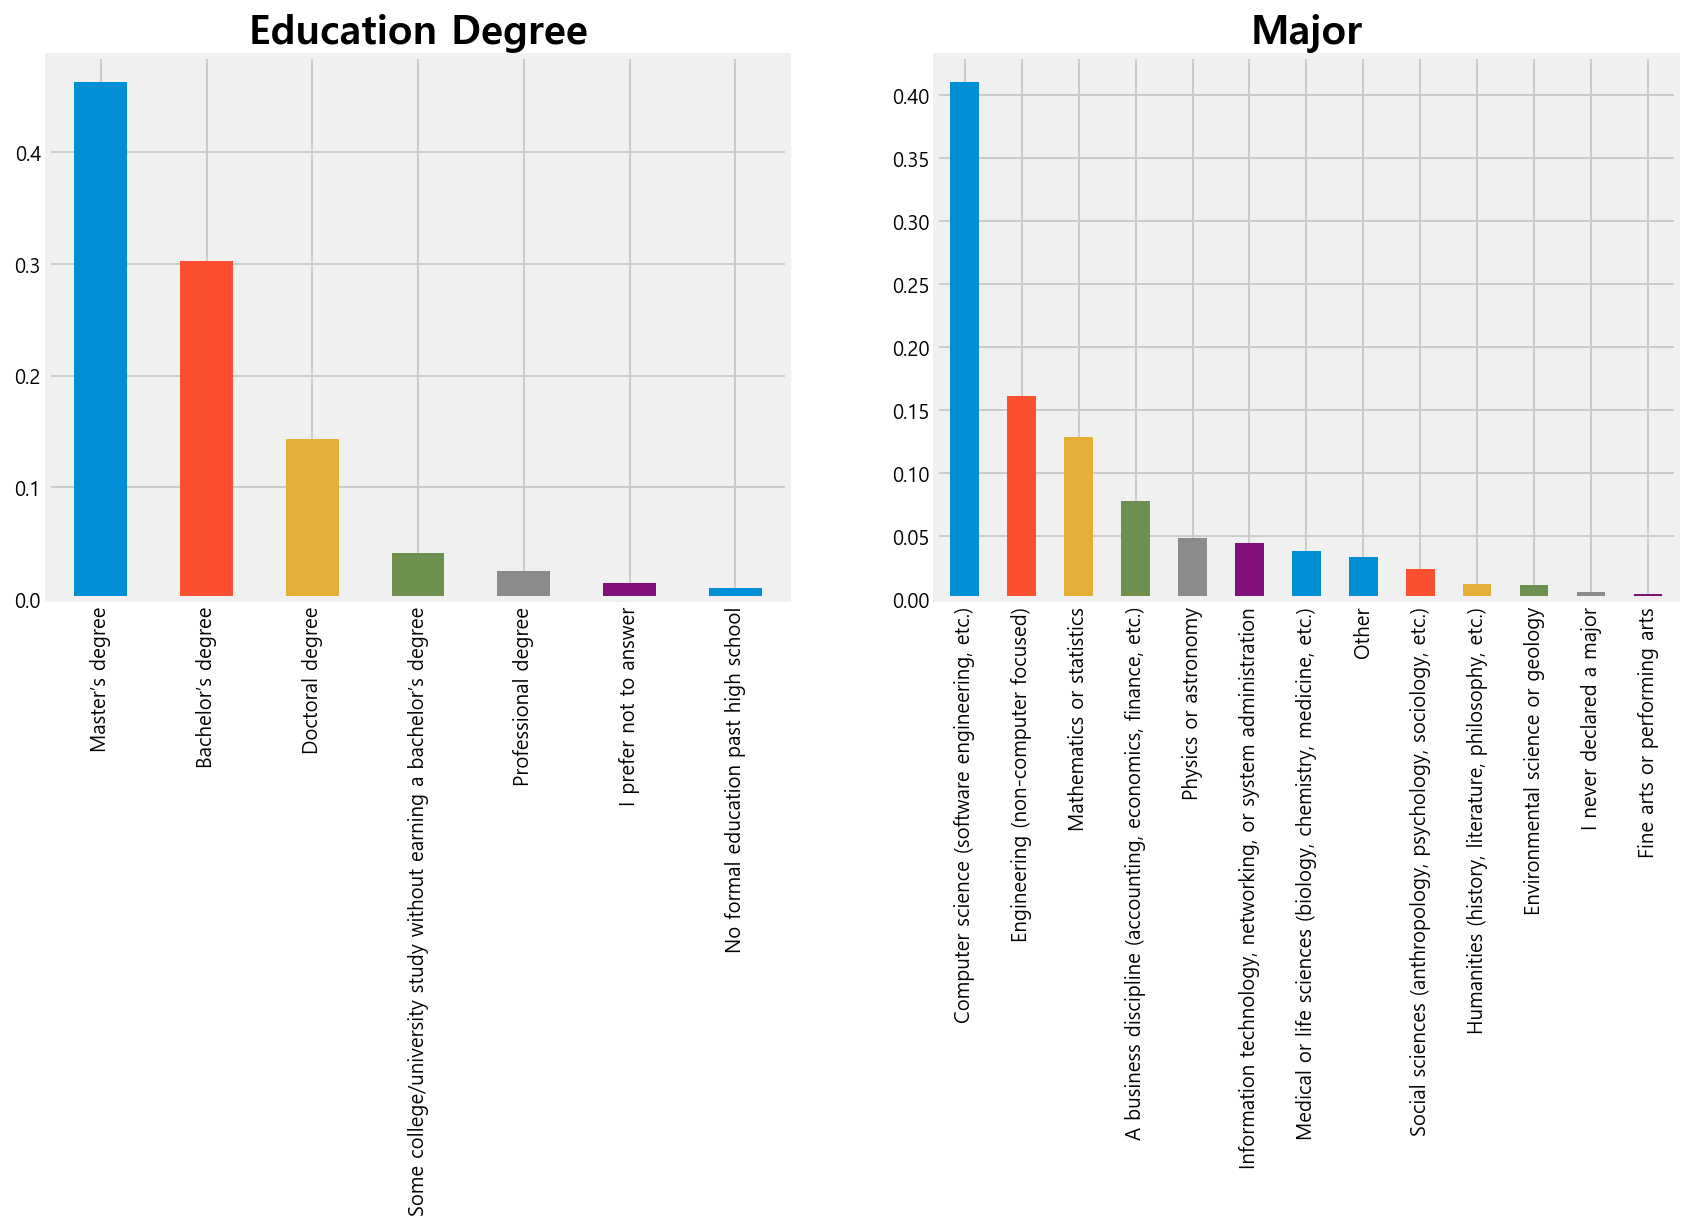

In [8]:
f, ax = plt.subplots(1,2,figsize=(13,5))
per_df('Q4').sort_values(ascending=False).plot.bar(ax=ax[0]).set_title('Education Degree', fontdict=fontdict)
per_df('Q5').plot.bar(ax=ax[1]).set_title('Major', fontdict=fontdict)

Text(0.5,1,'Industry')

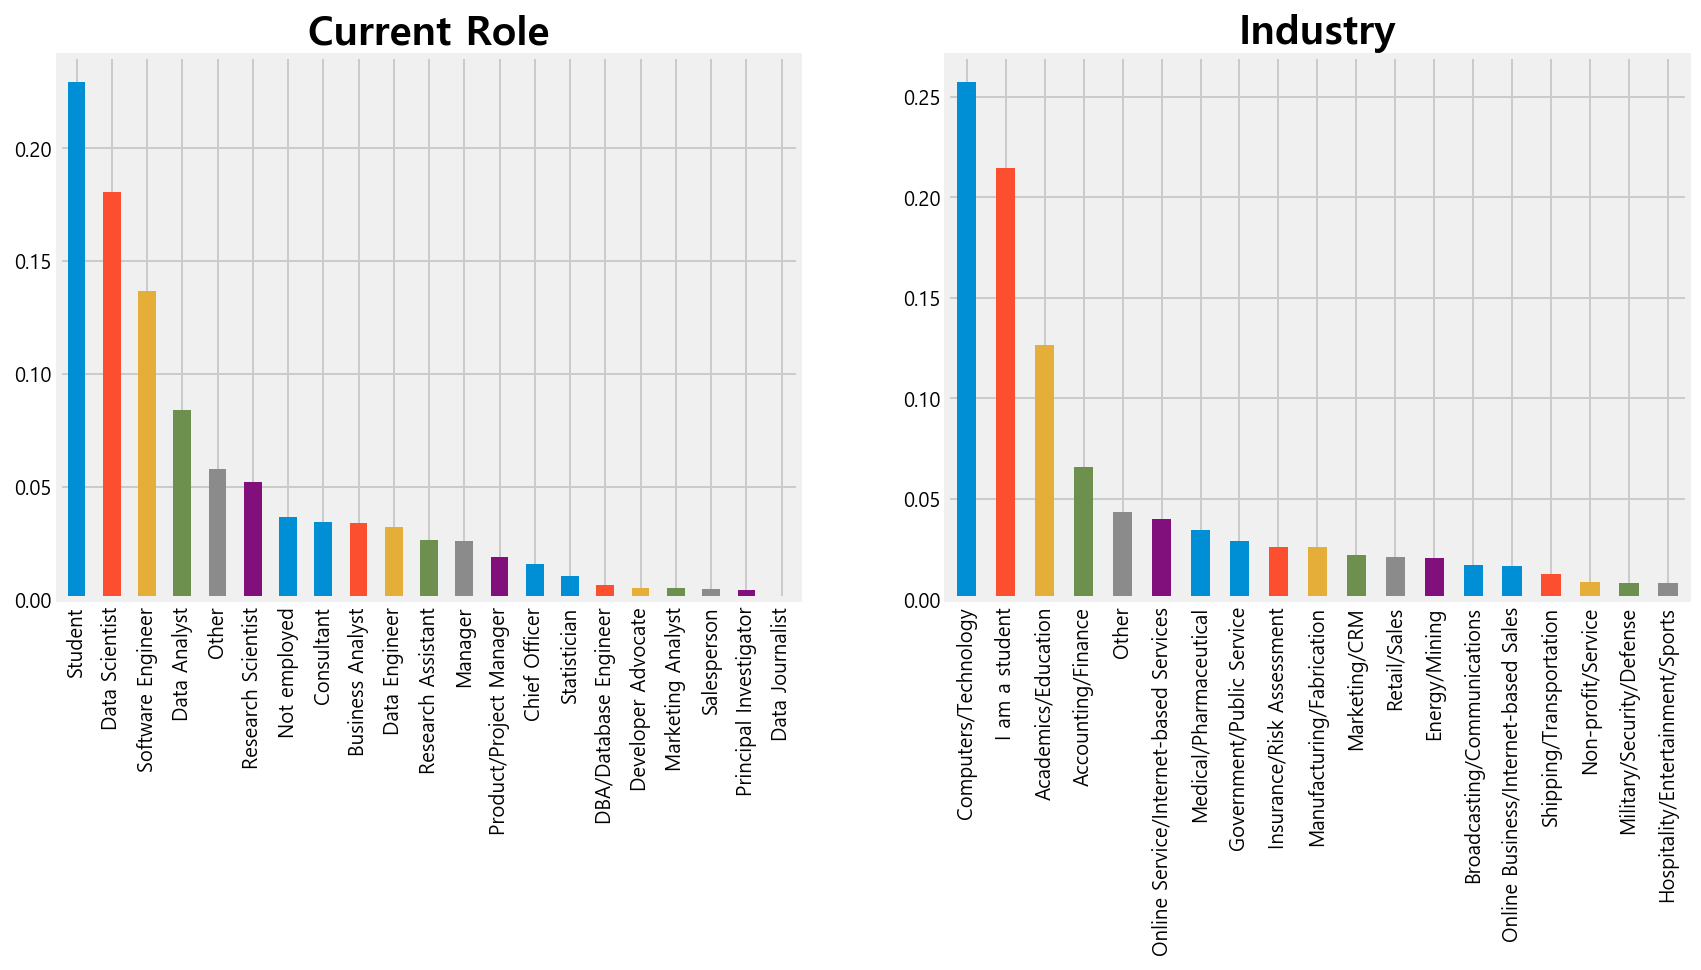

In [9]:
f, ax = plt.subplots(1,2,figsize=(13,5))
per_df('Q6').sort_values(ascending=False).plot.bar(ax=ax[0]).set_title('Current Role', fontdict=fontdict)
per_df('Q7').plot.bar(ax=ax[1]).set_title('Industry', fontdict=fontdict)

Text(0.5,1,'Compensation')

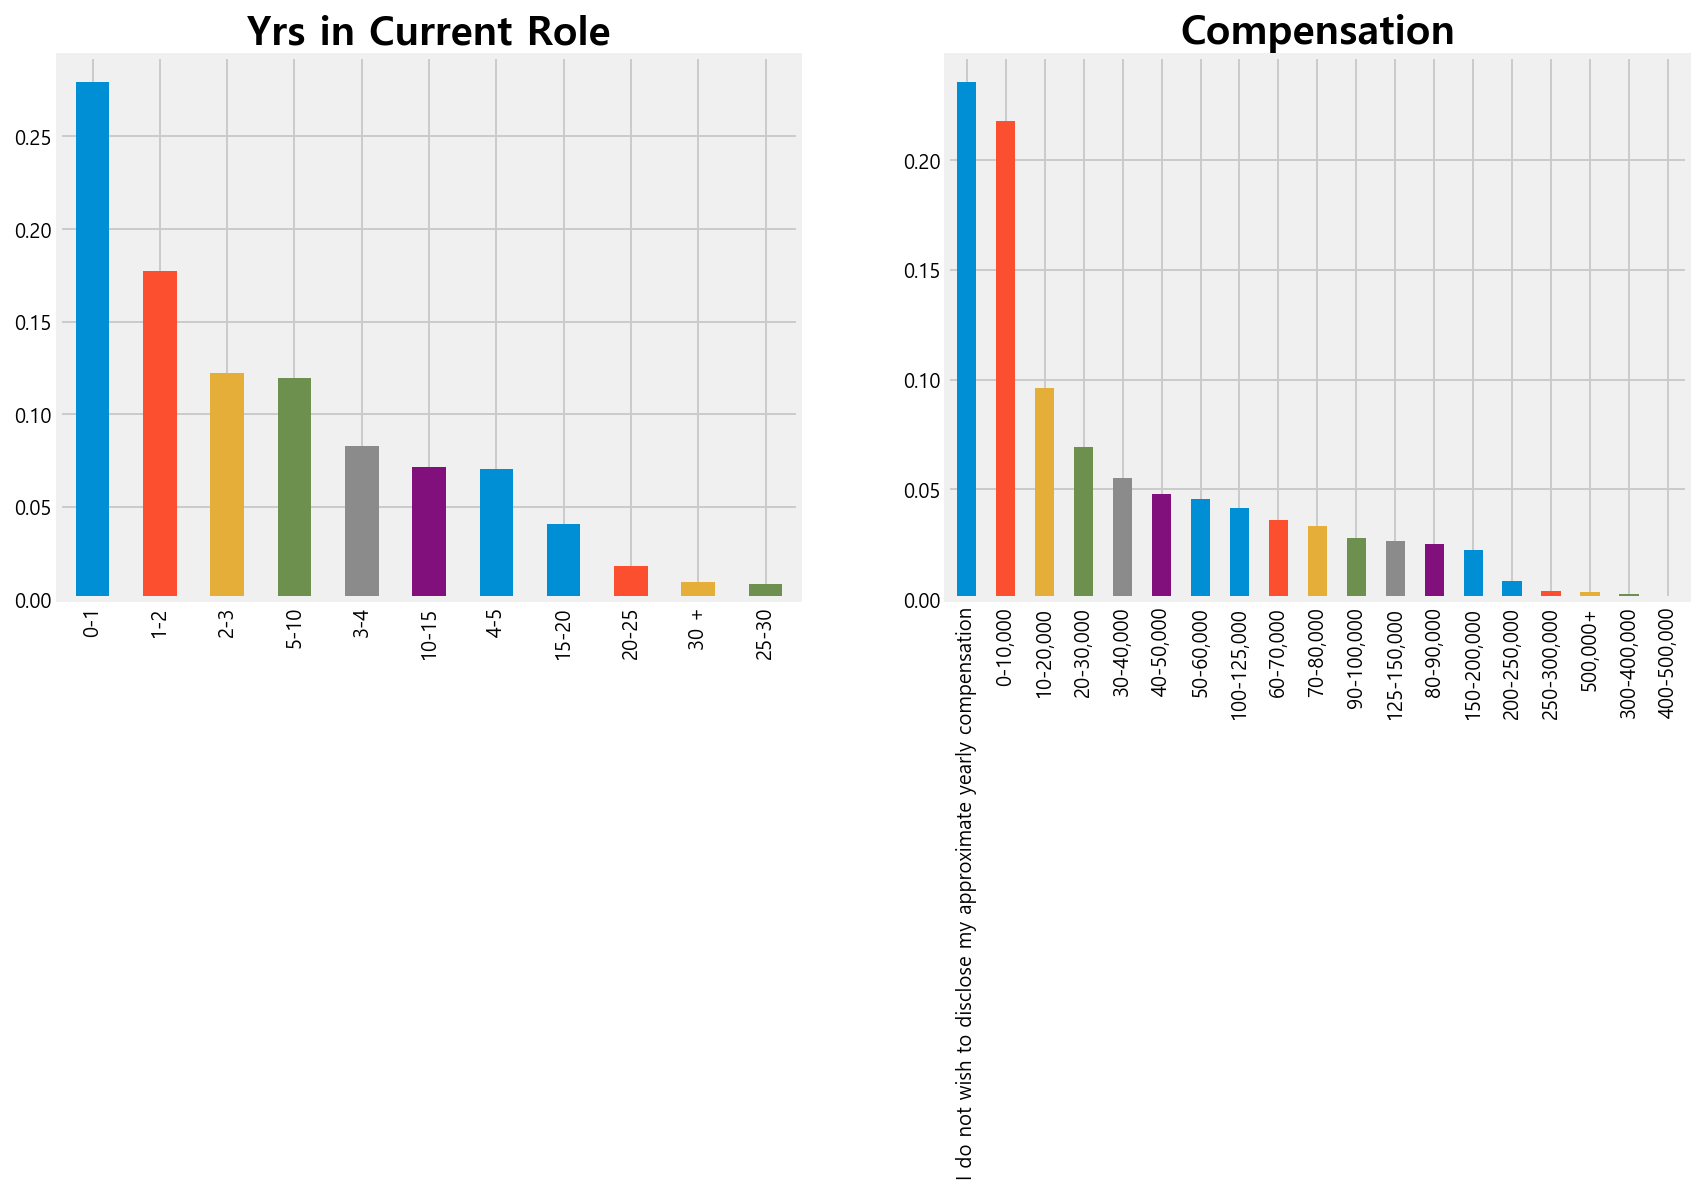

In [10]:
f, ax = plt.subplots(1,2,figsize=(13,5))
per_df('Q8').sort_values(ascending=False).plot.bar(ax=ax[0]).set_title('Yrs in Current Role', fontdict=fontdict)
per_df('Q9').plot.bar(ax=ax[1]).set_title('Compensation', fontdict=fontdict)

Text(0.5,1,'Using machine learning in company')

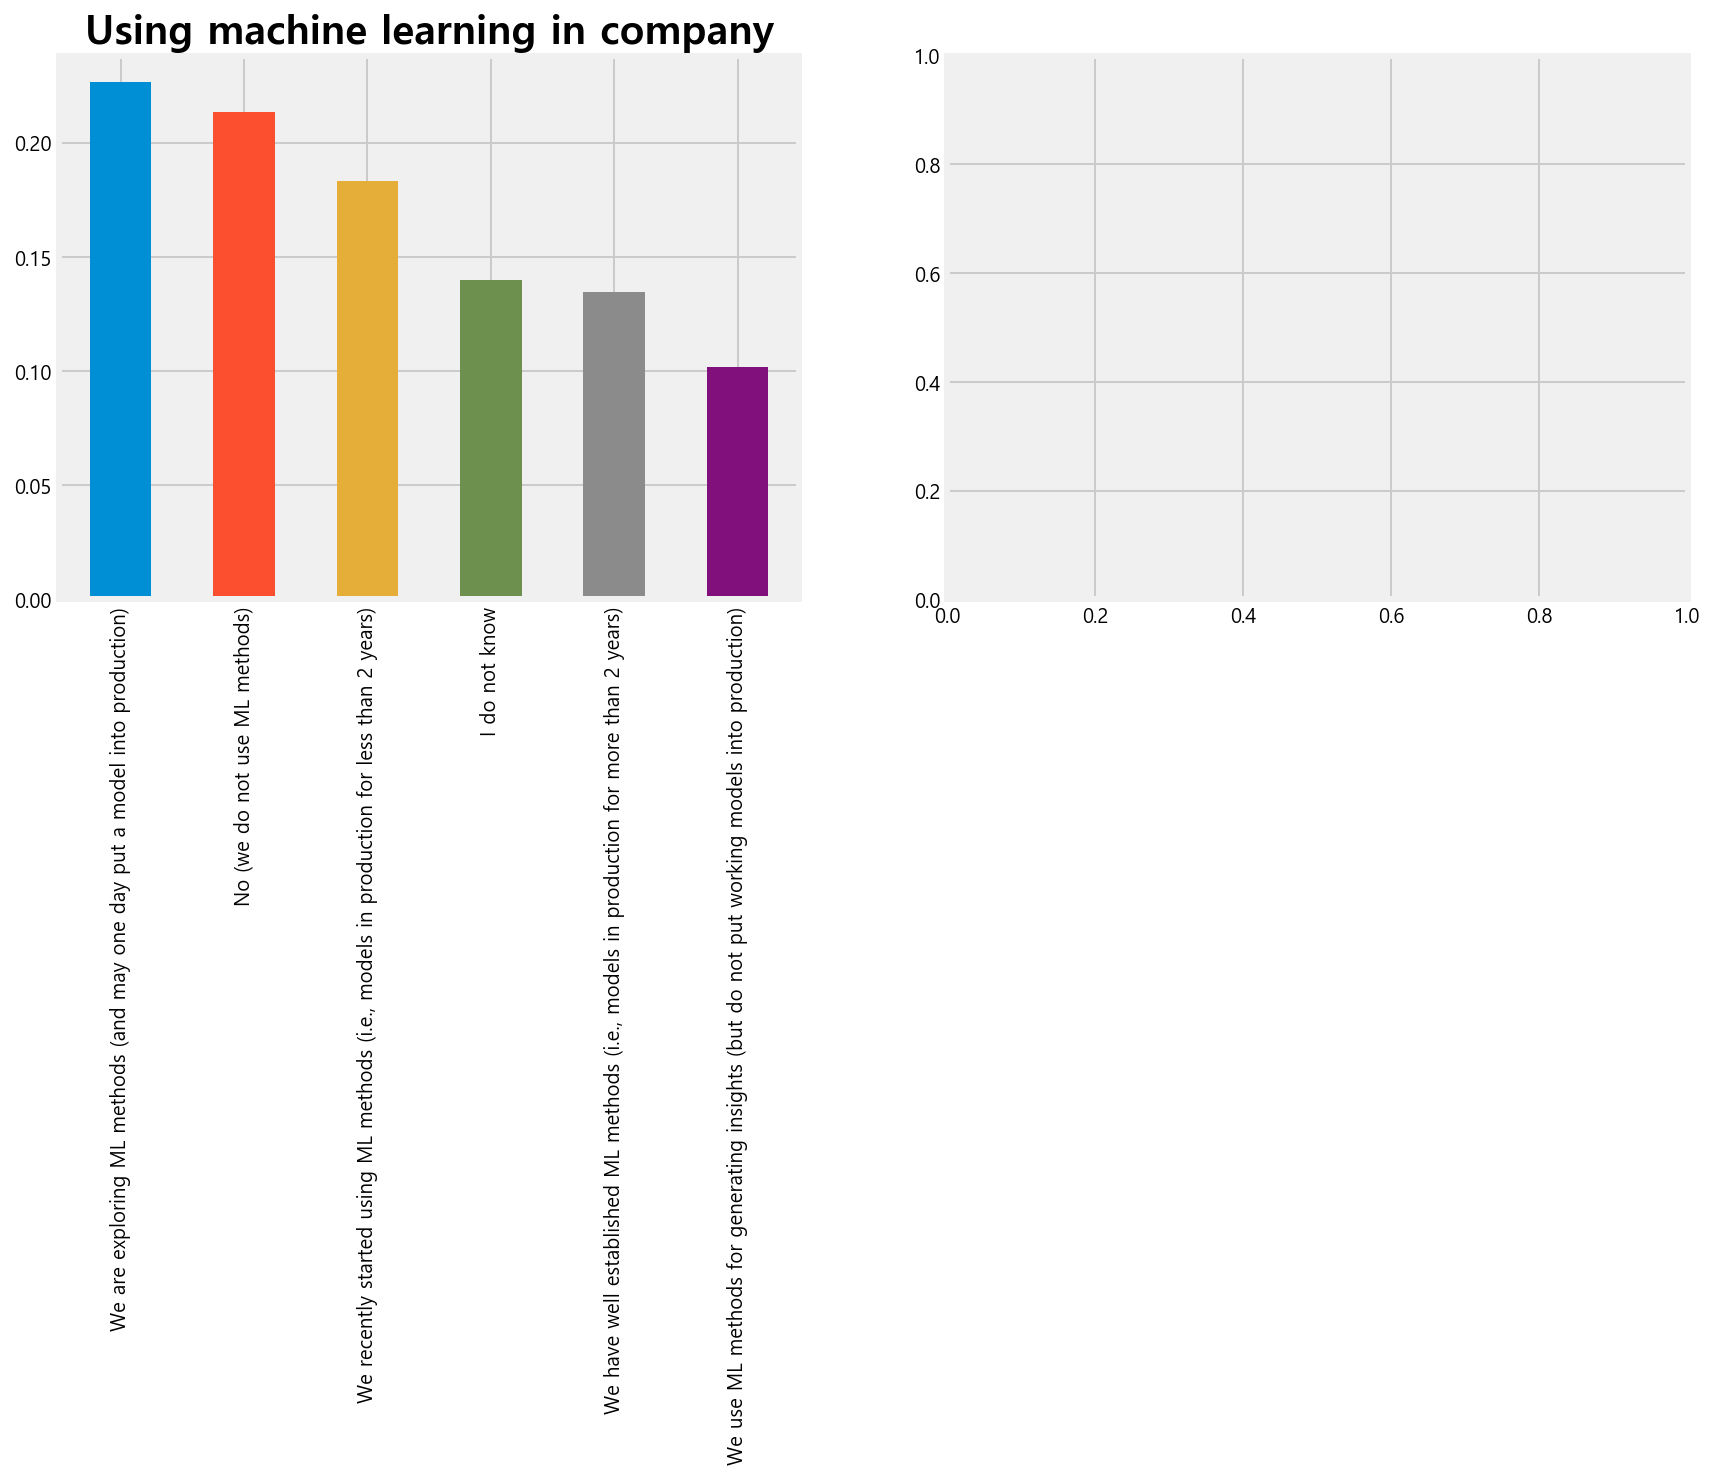

In [11]:
f, ax = plt.subplots(1,2,figsize=(13,5))
per_df('Q10').sort_values(ascending=False).plot.bar(ax=ax[0]).set_title('Using machine learning in company', fontdict=fontdict)

In [12]:
b_list = []
for a in [c for c in qn_list if 'Select any' in c] :
    b = a.split('- ')[-1]
    b_list.append(b)    

Text(0.5,1,'Which is your IDE')

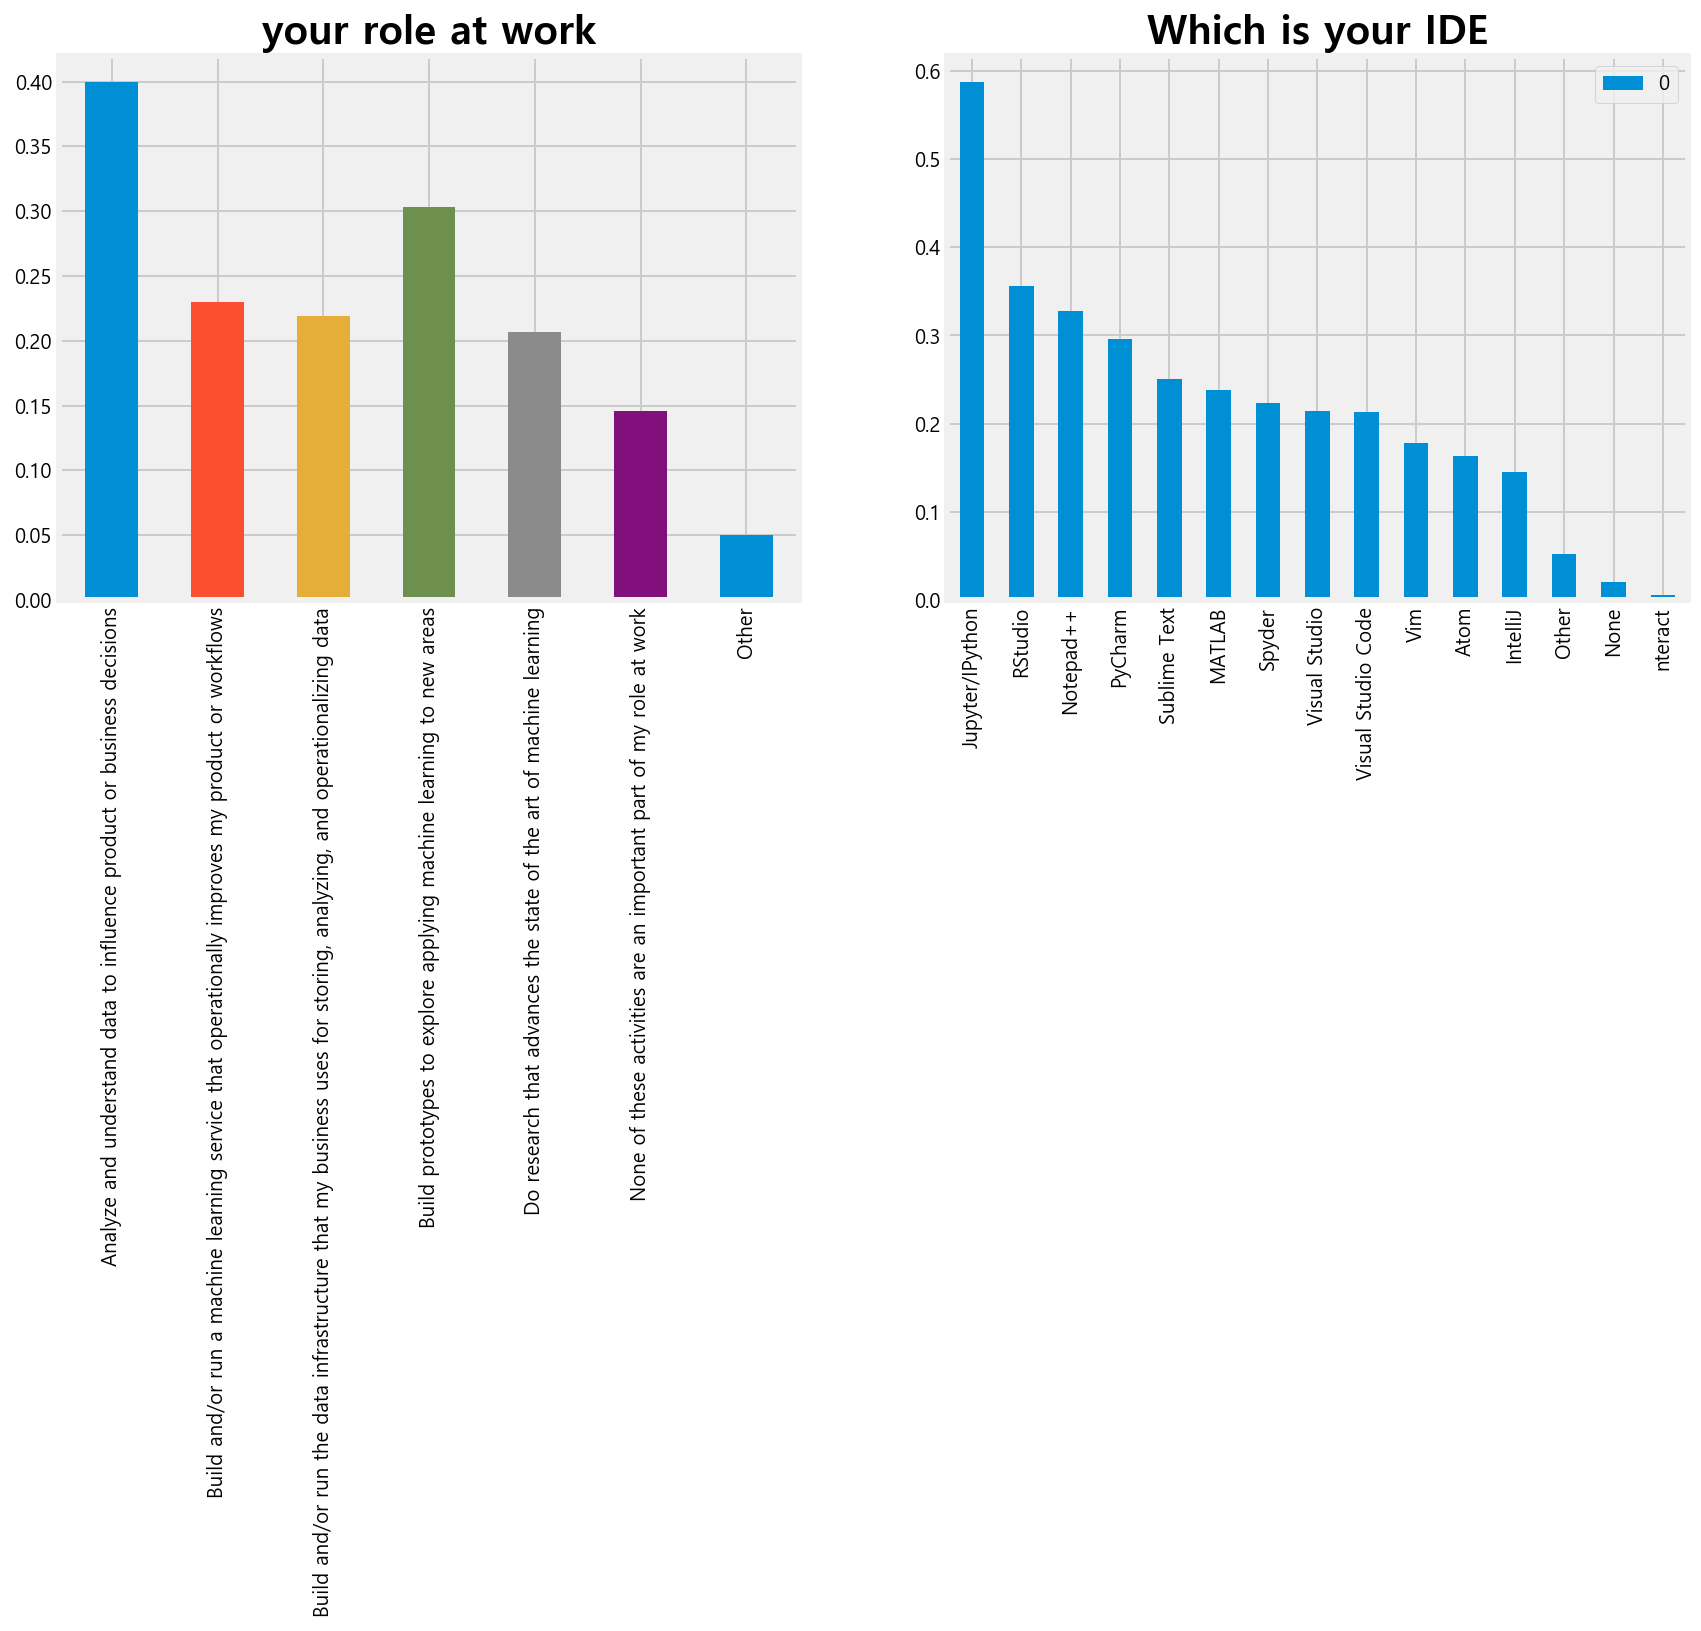

In [13]:
f, ax =plt.subplots(1,2,figsize=(13,5))
col = [ c for c in survey_multi.columns if 'Q11_Part' in c]
part_qn = survey_multi[col]
part_qn_binary = part_qn.fillna(0).replace('[^\\d]',1, regex=True)
g = (part_qn_binary.sum() / part_qn_binary.count()).plot.bar(ax=ax[0])
g.set_xticklabels(b_list)
g.set_title('your role at work', fontdict=fontdict)

# 13번 질문 하는 법 (어떤 IDE 쓰는지)
ide_qn_list =[c for c in qn_list if 'IDE' in c]
b_list = []
for a in ide_qn_list :
    b = a.split('- ')
    b_list.append(b[-1])    
    
col2 = [ c for c in survey_multi.columns if 'Q13_Part' in c]
ide_qs = survey_multi[col2]
ide_qs_binary = ide_qs.fillna(0).replace('[^\\d]',1, regex=True)

Q13_df = pd.DataFrame((ide_qs_binary.sum() / ide_qs_binary.count()))
Q13_df.index=b_list[:-1]

g = Q13_df.sort_values(by=0,ascending=False).plot.bar(ax=ax[1])
g.set_title('Which is your IDE', fontdict=fontdict)

Text(0.5,1,'Following hosted notebooks')

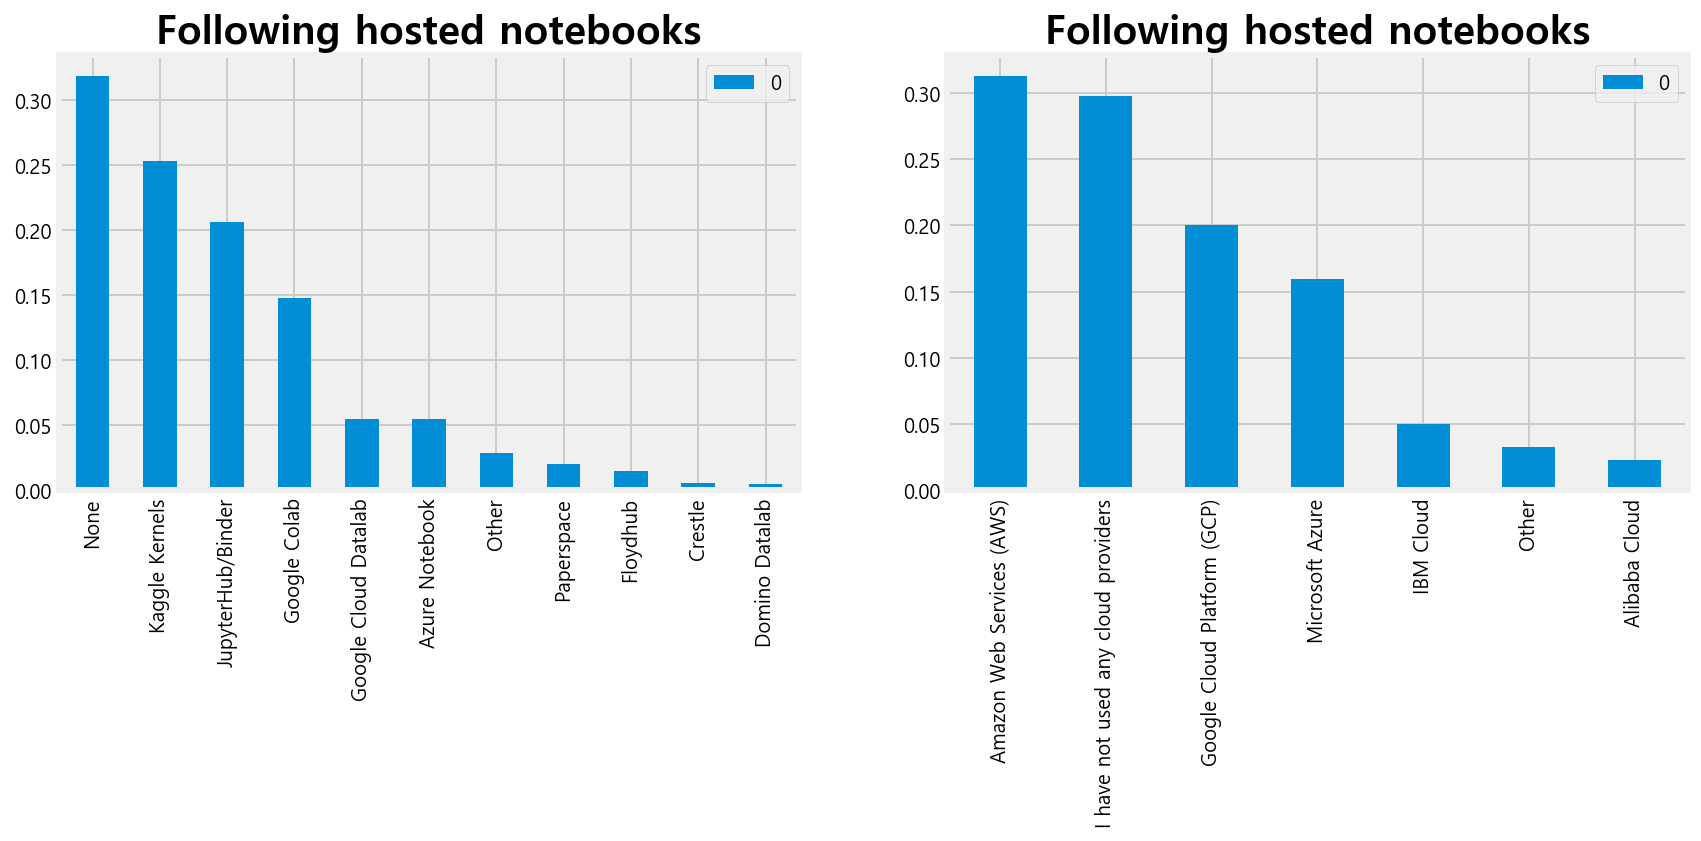

In [14]:
f, ax = plt.subplots(1,2,figsize=(13,4))
ide_qn_list =[c for c in qn_list if 'hosted notebooks' in c]
b_list = []
for a in ide_qn_list :
    b = a.split('- ')
    b_list.append(b[-1])   
    
col2 = [ c for c in survey_multi.columns if 'Q14_Part' in c]
ide_qs = survey_multi[col2]
ide_qs_binary = ide_qs.fillna(0).replace('[^\\d]',1, regex=True)

Q14_df = pd.DataFrame((ide_qs_binary.sum() / ide_qs_binary.count()))
Q14_df.index=b_list[:-1]

g = Q14_df.sort_values(by=0,ascending=False).plot.bar(ax=ax[0])
g.set_title('Following hosted notebooks', fontdict=fontdict)

ide_qn_list =[c for c in qn_list if 'cloud computing service' in c]
b_list = []
for a in ide_qn_list :
    b = a.split('- ')
    b_list.append(b[-1])   
    
col2 = [ c for c in survey_multi.columns if 'Q15_Part' in c]
ide_qs = survey_multi[col2]
ide_qs_binary = ide_qs.fillna(0).replace('[^\\d]',1, regex=True)

Q15_df = pd.DataFrame((ide_qs_binary.sum() / ide_qs_binary.count()))
Q15_df.index=b_list[:-1]

g = Q15_df.sort_values(by=0,ascending=False).plot.bar(ax=ax[1])
g.set_title('Following hosted notebooks', fontdict=fontdict)

Text(0.5,1,'Machine learning framework')

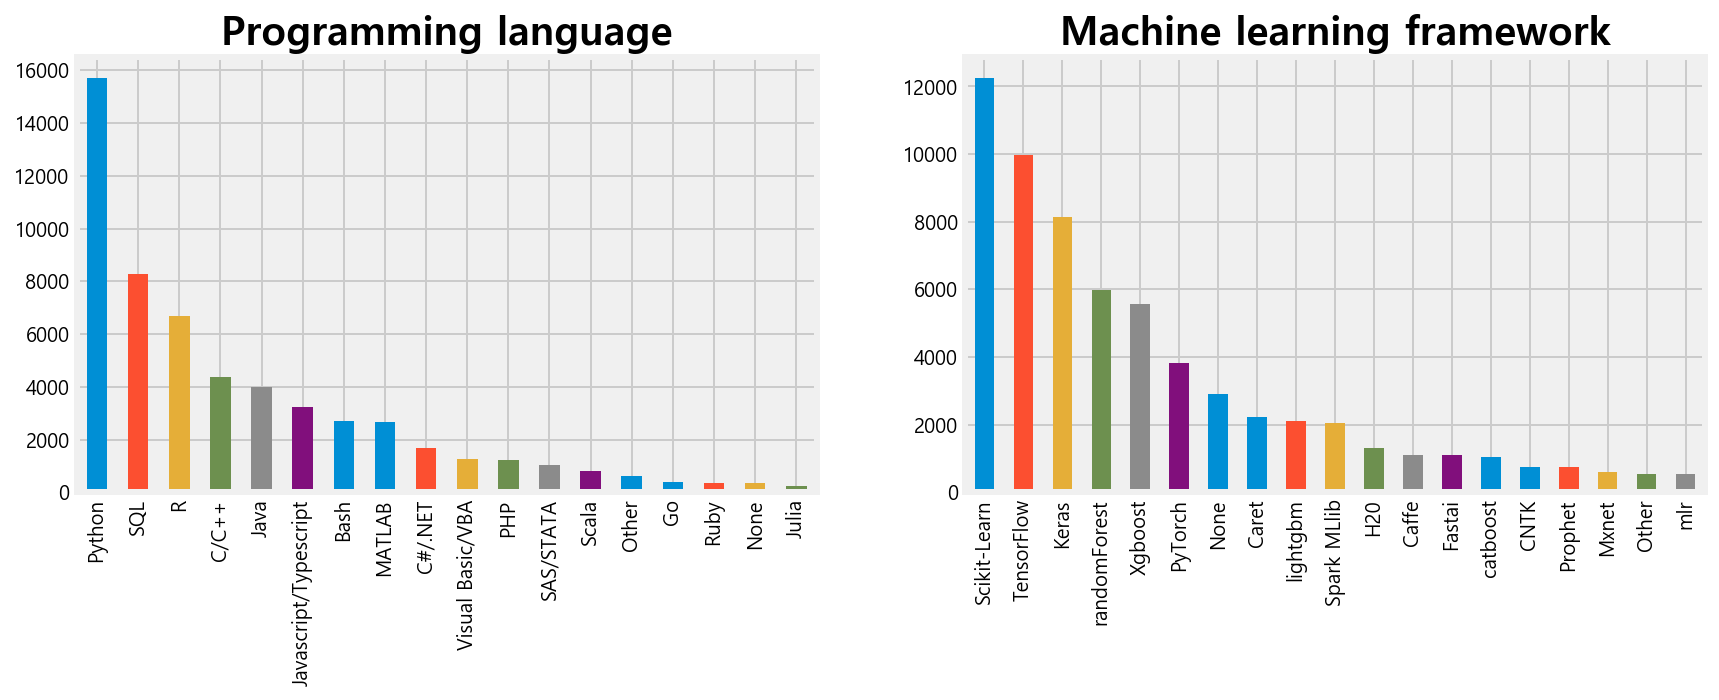

In [15]:
f, ax = plt.subplots(1,2,figsize=(13,4))
cols = [c for c in survey_multi.columns if 'Q16_Part' in c]
list_of_pl = survey_multi[cols].values.ravel().tolist()
list_of_pl = pd.Series([ide for ide in list_of_pl if isinstance(ide, str)])
pl_counts = list_of_pl.value_counts()

g = pl_counts.plot.bar(ax=ax[0])
g.set_title('Programming language', fontdict=fontdict)


cols = [c for c in survey_multi.columns if 'Q19_Part' in c]
list_of_pl = survey_multi[cols].values.ravel().tolist()
list_of_pl = pd.Series([ide for ide in list_of_pl if isinstance(ide, str)])
pl_counts = list_of_pl.value_counts()
g = pl_counts.plot.bar(ax=ax[1])
g.set_title('Machine learning framework', fontdict=fontdict)